In [28]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 10)

### Introduction
Video games have grown in popularity for entertainment, research, and social interaction. Minecraft, a very popular game globally, offers an open-world where players can do many things like building, exploring, and surviving. Its variety and broad appeal make it a great tool for studying player behavior. This data science project looks at player activity on a Minecraft server used for research by a Computer Science group at UBC. By tracking what players do and how long they play, the researchers hope to learn more about how different players interact with the game. This will help them use their resources better and attract the right players.  

**Main Question:**
"How do gender and experience levels influence the likelihood of players contributing a large amount of data, and how can we predict which gender and experience level combinations are associated with high-contributing players?"  

Dataset Overview
The project uses two datasets that provide important details about player actions and activities:

- players.csv:  

    This file lists all the unique players who have used the Minecraft server. It includes information about the players, such as their gender, experience level, and any other characteristics that affect their behavior.  

    Example columns:  

    - player_id: A unique code for each player.  

    - gender: The player's gender.  

    - experience: The player's experience level (e.g., Beginner, Regular, Veteran).  

    - age_group: The player's age range (if known).  

- sessions.csv:  

    This file keeps track of each player's individual game sessions, noting the changes in their activities during those sessions.  

    Example columns:  

    - session_id: A unique code for each session.  

    - player_id: The player involved in the session.  

    - duration: The length of the session in hours.  

    - actions_performed: The total number of actions done (e.g., building, mining, exploring).
 
    - resources_used: The amount of resources used.   

The datasets together give us the information we need to predict which players will contribute a lot of data. By looking at player demographics from players.csv and combining that with their behavior and activity levels from sessions.csv, we can create a model that shows which types of players (like gender, experience, or how they play) are most likely to produce a lot of data. This helps the research team know who to recruit and how to use server resources better.  

In [29]:
players <- read_csv('data/players.csv')|>
        select(experience, played_hours, gender) |>
        mutate(gender = as.factor(gender), experience = as.factor(experience))

players

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,played_hours,gender
<fct>,<dbl>,<fct>
Pro,30.3,Male
Veteran,3.8,Male
Veteran,0.0,Male
Amateur,0.7,Female
Regular,0.1,Male
⋮,⋮,⋮
Amateur,0.0,Female
Veteran,0.3,Male
Amateur,0.0,Prefer not to say


In [30]:
levels(players $ gender)

[1] "Agender"           "Female"            "Male"             
[4] "Non-binary"        "Other"             "Prefer not to say"
[7] "Two-Spirited"

In [31]:
encoded_players <- players |>
    mutate(encoded_experience = case_when(
        experience == "Amateur" ~ 1,
        experience == "Beginner" ~ 2,
        experience == "Regular" ~ 3,
        experience == "Pro" ~ 4,
        experience == "Veteran" ~ 5)) |>
    mutate(encoded_gender = case_when(
        gender == "Agender" ~ 1,
        gender == "Female" ~ 2,
        gender == "Male" ~ 3,
        gender == "Non-binary" ~ 4,
        gender == "Prefer not to say" ~ 5,
        gender == "Two-Spirited" ~ 6)) |>
    select(played_hours, encoded_experience, encoded_gender) |>
    filter(encoded_gender != 'NA')
    

(encoded_players)



played_hours,encoded_experience,encoded_gender
<dbl>,<dbl>,<dbl>
30.3,4,3
3.8,5,3
0.0,5,3
0.7,1,2
0.1,3,3
⋮,⋮,⋮
0.0,1,3
0.0,1,2
0.3,5,3


In [32]:
set.seed(1)
players_split <- initial_split(encoded_players, prop = .75, strata = played_hours)

players_training <- training(players_split)
players_testing <- testing(players_split)

In [33]:
set.seed(1)


players_recipe <- recipe(played_hours ~ ., data = players_training) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())


knn_spec <-  nearest_neighbor(weight_func = 'rectangular', neighbors = tune())|>
                    set_engine('kknn') |>
                    set_mode('regression')


players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

k_vals <-  tibble(neighbors = seq(1:50))

knn_fit <- workflow() |>
                add_recipe(players_recipe)|>
                add_model(knn_spec) |>
                tune_grid(resamples = players_vfold, grid = k_vals) |>
                collect_metrics()
# knn_fit

knn_results <- knn_fit |>
               filter(.metric == 'rmse') |>
               slice_min(std_err, n=1) |>
               select(neighbors)
knn_results

neighbors
<int>
3


In [34]:
set.seed(1)
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("regression")


players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    fit(data = players_training) 


players_final_summary <- players_fit |>
    predict(players_testing) |>
    bind_cols(players_testing) |>
    metrics(truth = played_hours, estimate = .pred) |> 
    filter(.metric == "rmse")

players_final_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,12.53435


In [35]:
values_experience <- players_fit |>
          predict(players_testing) |>
          bind_cols(players_testing) |>
          group_by(encoded_experience) |>
          summarize(mean_played_hours = mean(played_hours),
                    .pred = mean(.pred)) |>
          mutate(encoded_experience = as.factor(encoded_experience))
values_experience

values_gender <- players_fit |>
                  predict(players_testing) |>
                  bind_cols(players_testing) |>
                  group_by(encoded_gender) |>
                  summarize(mean_played_hours = mean(played_hours),
                    .pred = mean(.pred)) |>
          mutate(encoded_gender = as.factor(encoded_gender))
values_gender

encoded_experience,mean_played_hours,.pred
<fct>,<dbl>,<dbl>
1,0.4928571,0.07142857
2,3.4125000,0.03750000
3,1.4363636,10.88181818
4,0.4800000,0.30000000
5,0.3090909,0.07272727


encoded_gender,mean_played_hours,.pred
<fct>,<dbl>,<dbl>
2,0.7222222,13.29259259
3,1.5000000,0.07849462
4,0.7000000,0.03333333
5,0.0000000,0.24166667
6,0.0000000,0.13333333


No summary function supplied, defaulting to `mean_se()`


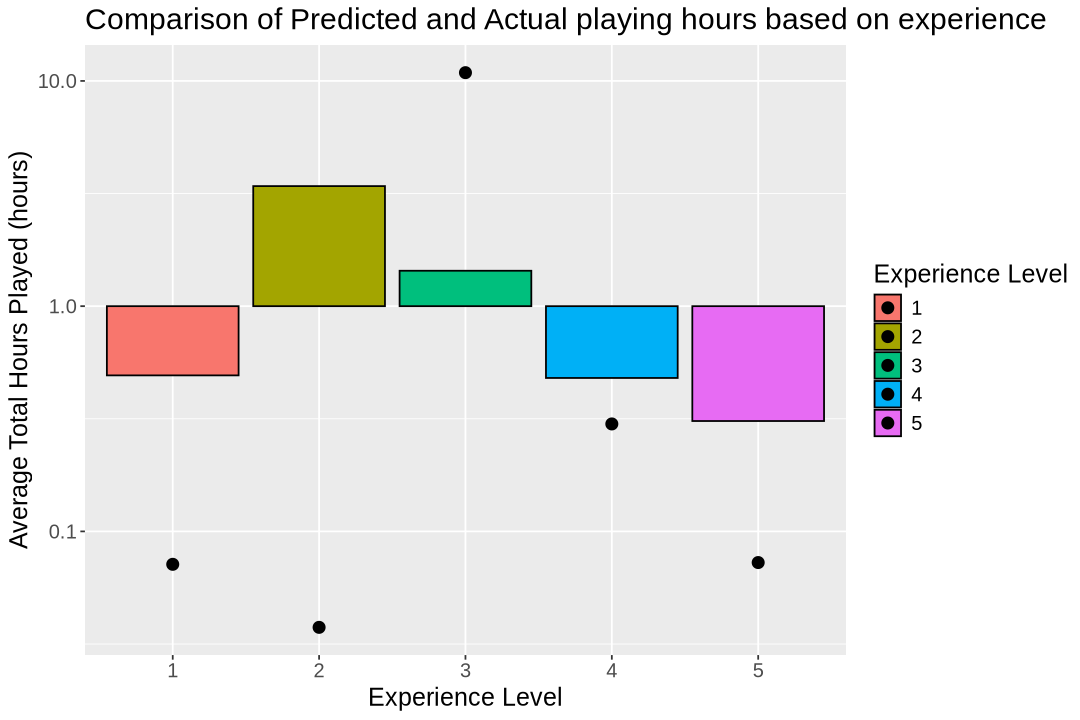

In [43]:
options(repr.plot.width = 9, repr.plot.height = 6)

players_experience_pred_plot <- ggplot(values_experience, aes(x = encoded_experience, y = mean_played_hours, fill = encoded_experience)) +
    geom_bar(stat = "summary", color = "black") +
    geom_point(aes(y = .pred), size = 3) +
    scale_y_log10() +
    labs(title = "Comparison of Predicted and Actual playing hours based on experience",
         x = "Experience Level", 
         y = "Average Total Hours Played (hours)",
         fill = 'Experience Level') + 
    theme(text = element_text(size = 15))
    
players_experience_pred_plot

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_summary()`).”
No summary function supplied, defaulting to `mean_se()`


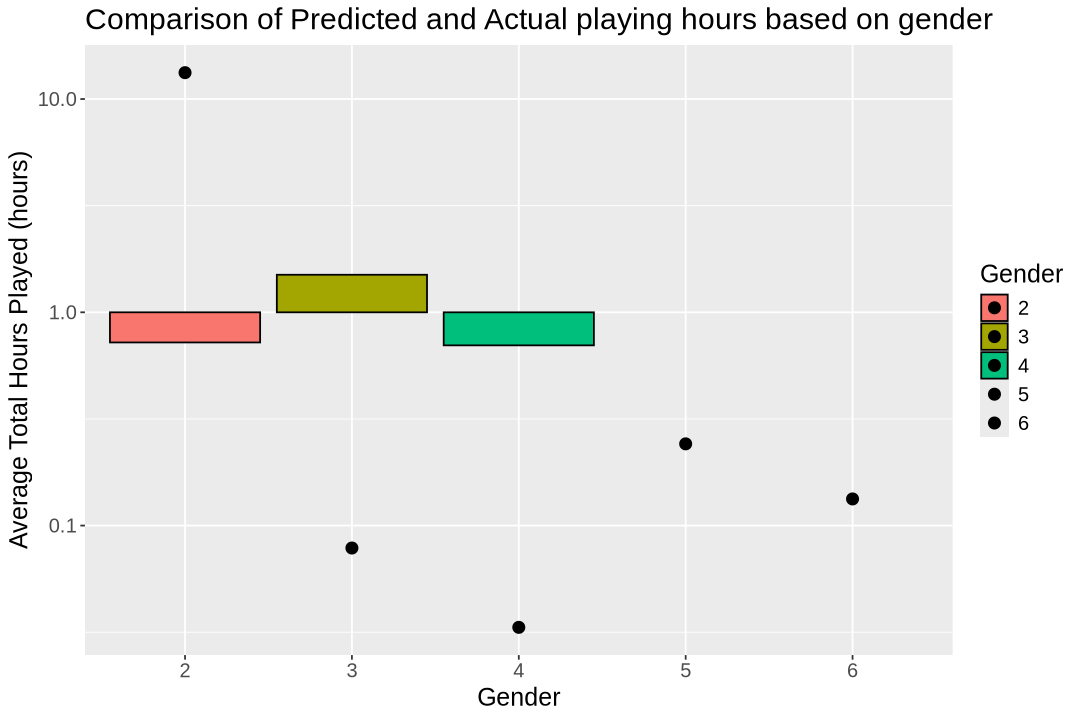

In [44]:
options(repr.plot.width = 9, repr.plot.height = 6)

players_gender_pred_plot <- ggplot(values_gender, aes(x = encoded_gender, y = mean_played_hours, fill = encoded_gender)) +
    geom_bar(stat = "summary", color = "black") +
    geom_point(aes(y = .pred), size = 3) +
    scale_y_log10() +
    labs(title = "Comparison of Predicted and Actual playing hours based on gender",
         x = "Gender", 
         y = "Average Total Hours Played (hours)",
         fill = 'Gender') + 
    theme(text = element_text(size = 15))
    
players_gender_pred_plot

**Results By Experience**:  
Players at Experience Level 2 (Beginner) spend the most time playing, averaging 3.41 hours. But the model greatly underestimates this, predicting only 0.04 hours. This shows that the model has trouble understanding the habits of beginner players. On the other hand, players at Experience Level 3 (Regular) actually play for 1.43 hours on average, but the model overestimates this to 10.88 hours. This shows a big overestimation for regular players.

For other levels, like Experience Levels 1 (Amateur), 4 (Pro), and 5 (Veteran), the actual playing time is lower, at 0.49, 0.48, and 0.31 hours respectively. The model does a bit better with these groups, predicting 0.07, 0.30, and 0.07 hours. But it still doesn't match the real data perfectly. This means the model is more accurate for less active players, but it still has trouble with the details.



**Results By Gender**:  
Gender 3 (Male) has the highest average actual playing hours, at 1.50, but the model greatly underestimates this group, predicting only 0.08 hours. This indicates that the model doesn't properly account for male players' behavior. Gender 2 (Female) has moderate actual playing hours at 0.72, but the model significantly overestimates their playing time at 13.29 hours, showing a strong bias in the predictions.

For Genders 4 (Non-binary), 5 (Prefer not to say), and 6 (Two-Spirited), the actual playing hours are either very low (0.7 for Non-binary) or zero (0.0 for Prefer not to say and Two-Spirited). The model's predictions for these groups (0.03, 0.24, and 0.13, respectively) are closer but still not accurate. This suggests that more data is needed to improve predictions for underrepresented groups.

**SUMMARY**  

This study on Minecraft players' playtime based on gender and experience showed significant differences between the actual hours played and the predicted hours. Beginners (Experience Level 2) played the most, with 3.41 hours, but their predicted playtime was much lower at 0.04 hours. Regular players (Experience Level 3) were predicted to play much more (10.88 hours) than they actually did (1.43 hours). For gender, males (Gender 3) had the highest average playtime (1.50 hours) but were predicted to play much less (0.08 hours). Females (Gender 2) played for a moderate amount of time (0.72 hours), but the prediction was much higher at 13.29 hours. Genders that are less common, like Non-binary (4) and Two-Spirited (6), had very low actual and predicted playtimes, showing some agreement but still not enough data.

The findings only partially aligned with expectations. It was anticipated that experienced players and more engaged demographics would exhibit higher playing hours. However, the significant underestimation of Beginners and certain gender groups, coupled with the overestimation of Regular players and others, was surprising. This indicates potential biases in the data or assumptions made by the model. Additionally, while predictions for underrepresented genders were relatively closer to actual hours, their low engagement suggests gaps in representation that require further exploration.


These results could change how Minecraft developers and researchers view player involvement. If they don't realize how much time new players spend, they might miss chances to keep these players interested. If they think regular players and women play more than they actually do, they might use resources in the wrong way for these groups. 

**Future Questions**  
This study brings up several key questions:  


Data Collection: Are there biases in how data is gathered that affect results differently for men and women or for players with different levels of experience?  

Behavioral Patterns: Why do new players participate more than others, and how can this information help improve game design and keep players coming back?  

  Model Refinement: What other factors, like how people play, how long they play, or what they aim to achieve, could make predictions more accurate?  
  
  Inclusion: How can we gather more data from underrepresented groups to better understand how they interact with Minecraft?  
  
Cultural Influence: Do cultural aspects affect how much people play, and might these influences vary between men and women or between beginners and experienced players?  

